# Imports

In [1]:
# Data Processing
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import interpolate
import numpy as np

# General
import os
import simplejson as json
import time
import copy


In [2]:
# Custom tools

def fit_line(x, y):
    '''
    Fits a line to an input set of points

    Returns a tuple of the x and y components of the line

    Adapted from: https://stackoverflow.com/a/31800660/6454085
    '''
    return np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))

def pad_with_zeros(a, new_length):
    '''
    Pads a 1D array with zeros

    If the array is less than the input length it will not be changed
    '''
    a = np.array(a)
    if a.shape[0] >= new_length:
        return a
    else:
        return np.pad(a, (0, new_length-a.shape[0]), mode='constant', constant_values=0)

def remap_array(a, low1, high1, low2, high2):
    '''
    Remaps a numpy array to a specific range
    '''
    return low2 + (high2 - low2) * (a - low1) / (high1 - low1)

def resample(x, n, kind='linear'):
    x = np.array(x)
    f = interpolate.interp1d(np.linspace(0, 1, x.size), x, kind)
    return f(np.linspace(0, 1, n))

    


# Firebase snapshot and other inputs

In [3]:
snapshot_folder = "firebase-snapshots"
snapshot_timestamp = 1598561814.367759


# Load data from Firebase
 The data is loaded from a .json file and converted into a pandas DataFrame, and a dictionary.
 For most of the processing we do, only the pandas dataframe [cycles_df] is necessary.
 It contains cycle-level data about:
 <br>
 - The start and end of a cycle
 - The control scheme that was used
 - The status of the cycle (incomplete or complete)
 - The pose (X, Y, and Theta) of the target

The dictionary [action_list] is organized by interfaceID, and contains all the action chains that made up cycles
It is used to calcuate specific data about specific actions (for example % of time spent orienting vs translating)


In [4]:

with open(os.path.join(snapshot_folder, str(snapshot_timestamp) + ".json")) as f:
    json_snapshot = json.load(f)

print("Loaded snapshot {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(snapshot_timestamp))))


Loaded snapshot 2020-08-27 13:56:54


In [5]:
# [interfaceIDs] is a set that contains one of each ID
# We use it later on to sparate the dataframe by interface
interfaceIDs = set()

cycle_data_columns = ["startTime", "endTime", "status", "control", "transitionType", "interfaceID", "targetX", "targetY", "targetTheta", "threshXY", "threshTheta"]
cycle_data = []

action_list = {}

for uid in json_snapshot:
    for sid in json_snapshot[uid]['sessions']:
        if 'cycles' in json_snapshot[uid]['sessions'][sid]:
            for cid in json_snapshot[uid]['sessions'][sid]['cycles']:
                cycle = json_snapshot[uid]['sessions'][sid]['cycles'][cid]

                if cycle['isTest']:
                    # Update cycle_data with general information about the cycle
                    startTime = cycle['startTime']['timestamp'] / 1000
                    status = cycle['status']

                    # There is no end timestamp if the cycle is incomplete
                    endTime = startTime
                    if status == "complete":
                        endTime = cycle['endTime']['timestamp'] / 1000

                    control = cycle['control']
                    transitionType = cycle['transitionType']
                    interfaceID = control + "." +transitionType

                    interfaceIDs.add(interfaceID)

                    targetX = cycle['targetPose']['x']
                    targetY = cycle['targetPose']['y']
                    targetTheta = cycle['targetPose']['theta']
                    threshXY = cycle['targetPose']['threshXY']
                    threshTheta = cycle['targetPose']['threshTheta']

                    cycle_data.append([startTime, endTime, status, control, transitionType, interfaceID, targetX, targetY, targetTheta, threshXY, threshTheta])

                    # Update action_list with the set of actions for this cycle
                    if 'events' in cycle: # Sometimes the last cycle of a session has no action so we skip it
                        actions = []
                        for aid in cycle['events']:

                            # We want to ignore any events that are just ee pose logs, and only keep user actions
                            if cycle['events'][aid]['type'] != 'pose':
                                # We want to remove any actions that are just a release of the cursor
                                action_type = cycle['events'][aid]['newState']
                                if action_type != "cursor-free":
                                    actions.append(action_type)
                                elif interfaceID == "target.click" or interfaceID == "targetdrag.click":
                                    actions.append(action_type)
                        
                        if interfaceID in action_list:
                            action_list[interfaceID].append(actions)
                        else:
                            action_list[interfaceID] = [actions]


In [6]:
cycles_df = pd.DataFrame(cycle_data, columns=cycle_data_columns)
cycles_df['cycleLength'] = cycles_df['endTime'] - cycles_df['startTime']
# Calculate the euclidean distace between where the ee starts (357, 249) and the target
cycles_df['targetDistance'] = ((cycles_df['targetX'] - 357) ** 2 + (cycles_df['targetY'] - 249) ** 2) ** 0.5
cycles_df = cycles_df[cycles_df["status"] == "complete"]

interface_dfs = {}
for interfaceID in interfaceIDs:
    interface_dfs[interfaceID] = cycles_df[cycles_df["interfaceID"] == interfaceID]

cycles_df.head()


startTime       endTime    status control transitionType interfaceID  \
0  1.598547e+09  1.598547e+09  complete    drag          click  drag.click   
2  1.598547e+09  1.598547e+09  complete    drag          click  drag.click   
3  1.598547e+09  1.598547e+09  complete    drag          click  drag.click   
4  1.598547e+09  1.598547e+09  complete    drag          click  drag.click   
5  1.598547e+09  1.598547e+09  complete    drag          click  drag.click   

      targetX     targetY  targetTheta   threshXY  threshTheta  cycleLength  \
0  194.912336  395.487907   164.110635   5.289923    53.120297        5.811   
2  429.066383  293.005850   158.408620  23.413260    47.144716        3.545   
3  324.585362  280.647299   178.466710   5.078163    29.807677        4.157   
4  257.258049  119.795470   151.141769  11.853029    38.378933        4.638   
5  186.921708   98.514276   -80.386234  24.397809    15.031804        2.864   

   targetDistance  
0      218.474524  
2       84.439792  
3       45.301880  
4      163.224592  
5      227.095968

# Time stats per interface

In [7]:
for interfaceID in interface_dfs:
    interface_df = interface_dfs[interfaceID]

    print(interfaceID)
    print("Mean:", np.mean(interface_df['cycleLength']))
    print("Standard Deviation:",np.std(interface_df['cycleLength']))
    print("Min:",np.min(interface_df['cycleLength']))
    print("Max:",np.max(interface_df['cycleLength']))
    print()



drag.press/release
Mean: 3.9966666301091514
Standard Deviation: 0.7673715870163114
Min: 3.117000102996826
Max: 5.4679999351501465

panel.press/release
Mean: 7.879999995231628
Standard Deviation: 5.801642138662418
Min: 2.5789999961853027
Max: 19.812000036239624

targetdrag.click
Mean: 2.1069444682863026
Standard Deviation: 0.5576199346757542
Min: 1.4449999332427979
Max: 3.8960001468658447

drag.click
Mean: 3.9318571431296214
Standard Deviation: 1.0119711922097288
Min: 2.5910000801086426
Max: 5.810999870300293

arrow.click
Mean: 4.942333300908406
Standard Deviation: 0.7705810357413712
Min: 3.822000026702881
Max: 5.8379998207092285

targetdrag.press/release
Mean: 2.0656667153040567
Standard Deviation: 0.13949753972952403
Min: 1.874000072479248
Max: 2.311000108718872

arrow.press/release
Mean: 6.731500029563904
Standard Deviation: 3.1832529900122704
Min: 3.555999994277954
Max: 13.098999977111816

target.click
Mean: 2.5058333476384482
Standard Deviation: 0.5264945094910284
Min: 1.8210000991

# Time vs. Distance (Euclidean, Orientation, and Combined)
## Euclidean Distance vs Time

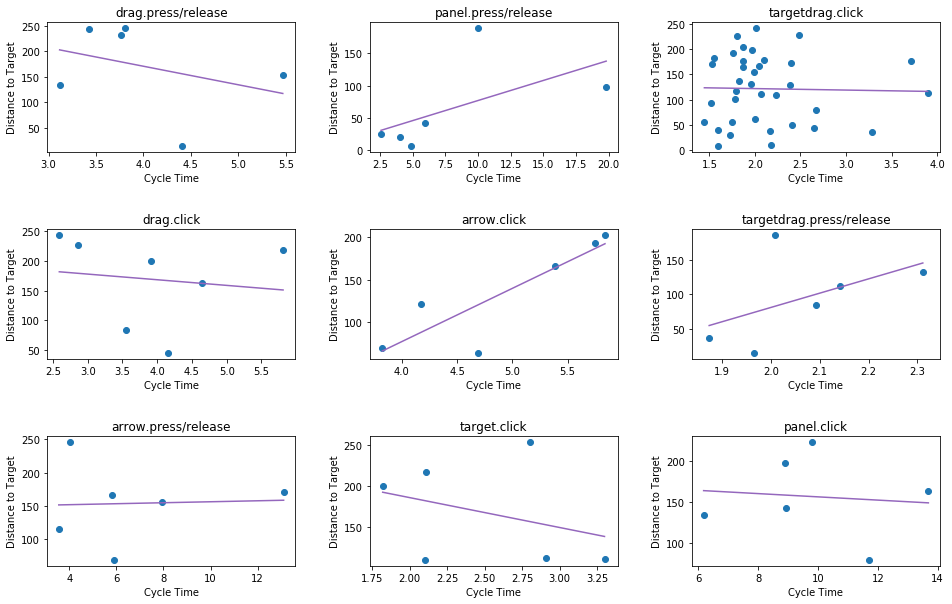

In [8]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]
    ax.scatter(interface_df['cycleLength'], interface_df['targetDistance'], c="tab:blue")
    
    line = fit_line(interface_df['cycleLength'], interface_df['targetDistance'])
    ax.plot(line[0], line[1], c="tab:purple")

    ax.set_xlabel('Cycle Time')
    ax.set_ylabel('Distance to Target')


## Orientation vs Time

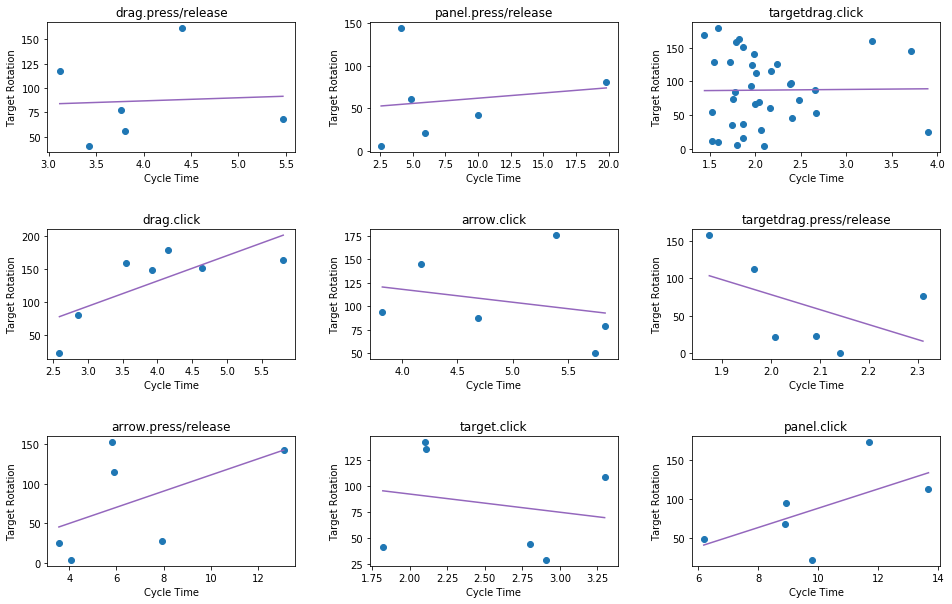

In [9]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]
    ax.scatter(interface_df['cycleLength'], np.abs(interface_df['targetTheta']), c="tab:blue")
    
    line = fit_line(interface_df['cycleLength'], np.abs(interface_df['targetTheta']))
    ax.plot(line[0], line[1], c="tab:purple")

    ax.set_xlabel('Cycle Time')
    ax.set_ylabel('Target Rotation')


## Distance + Orientation vs Time

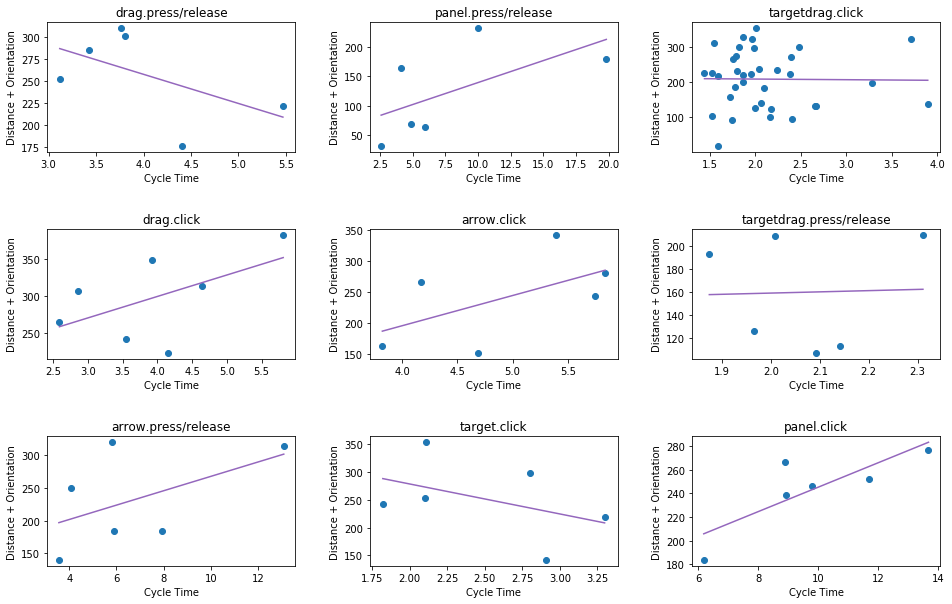

In [10]:

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]
    ax.scatter(interface_df['cycleLength'], np.abs(interface_df['targetTheta']) + interface_df['targetDistance'], c="tab:blue")
    
    line = fit_line(interface_df['cycleLength'], np.abs(interface_df['targetTheta']) + interface_df['targetDistance'])
    ax.plot(line[0], line[1], c="tab:purple")

    ax.set_xlabel('Cycle Time')
    ax.set_ylabel('Distance + Orientation')


# Action stats per interface
## Action Type vs Time

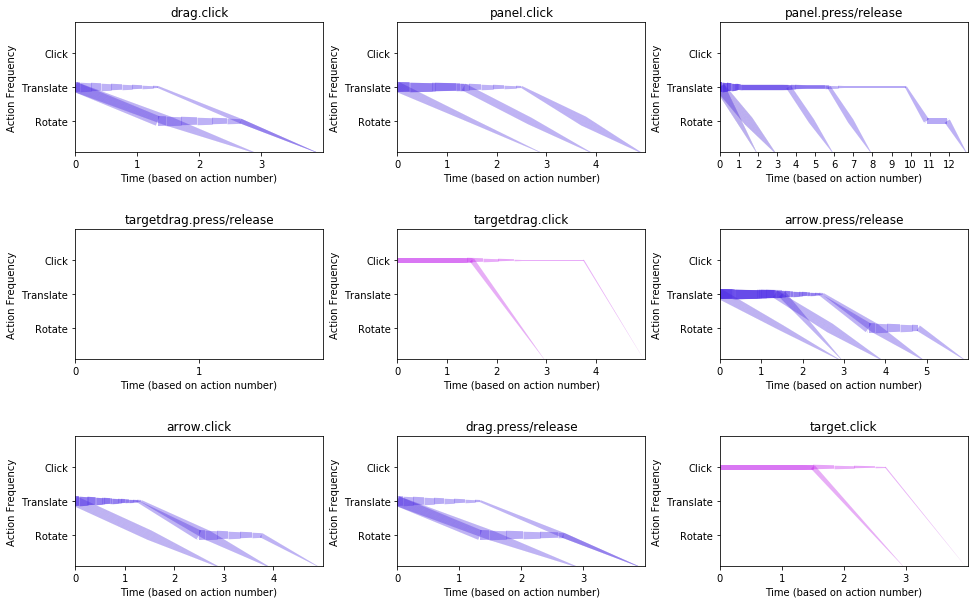

In [11]:
sample_num = 1000

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(action_list):
    rotation = np.array([])
    translation = np.array([])
    click = np.array([])
    for cycle in action_list[interfaceID]:
        for j, action in enumerate(cycle):
            
            if "rotating" in action:
                rotation = pad_with_zeros(rotation, j+1)
                rotation[j] += 1
            elif "translating" in action or "moving" in action:
                translation = pad_with_zeros(translation, j+1)
                translation[j] += 1
            elif "cursor" in action:
                click = pad_with_zeros(click, j+1)
                click[j] += 1
    
    if rotation.shape[0] != 0:
        rotation = remap_array(rotation, np.min(rotation), np.max(rotation), 2, 10)
    if translation.shape[0] != 0:
        translation = remap_array(translation, np.min(translation), np.max(translation), 2, 10)
    if click.shape[0] != 0:
        click = remap_array(click, np.min(click), np.max(click), 1, 5)

    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)

    drawn_lines = []

    for cycle in action_list[interfaceID]:
        numbered_cycle = []
        cycle_width = []
        for i, action in enumerate(cycle):
            if "rotating" in action:
                numbered_cycle.append(1)
                cycle_width.append(rotation[i])
            elif "translating" in action or "moving" in action:
                numbered_cycle.append(2)
                cycle_width.append(translation[i])
            elif "cursor" in action:
                numbered_cycle.append(3)
                cycle_width.append(click[i])
        
        drawn = False
        for line in drawn_lines:
            drawn = np.array_equal(numbered_cycle, line)
            if drawn: break
        if drawn: continue
        drawn_lines.append(copy.copy(numbered_cycle))
        
        numbered_cycle.append(0)
        cycle_width.append(0)

        color = np.array([])
        alpha = 100
        if numbered_cycle[0] == 1:
            color = np.array([214, 33, 79, alpha])
        elif numbered_cycle[0] == 2:
            color = np.array([73, 39, 230, alpha])
        elif numbered_cycle[0] == 3:
            color = np.array([193, 24, 237, alpha])
        
        cycle_len = len(numbered_cycle)
        y = resample(numbered_cycle, sample_num, kind='slinear')
        lwidths = resample(cycle_width, sample_num, kind='slinear')

        x = np.linspace(0, cycle_len, sample_num)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, linewidths=lwidths, color=color/255)
        ax.add_collection(lc)

    ax.set_xlabel('Time (based on action number)')
    ax.set_ylabel('Action Frequency')

    # The axis limits are not (0, 4) becase we don't want to see those labels
    ax.set_ylim([0.1, 3.9])
    ax.set_xlim([0, max(rotation.shape[0], translation.shape[0], click.shape[0])+1])

    # Lable the ticks
    ax.set_yticklabels(['','Rotate','Translate', 'Click'])

    # Force the x-axis tick interval to be 1
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
